In [1]:
import numpy as np
import pandas as pd
import time
from functools import partial

from scipy.stats import randint, uniform
from sim_lib import simulation

pd.options.mode.chained_assignment = None


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def eps_greedy(history: pd.DataFrame, eps: float):
    if uniform.rvs() < eps:
        n = history.shape[0]
        return history.index[randint.rvs(0, n)]

    ctr = history['clicks'] / (history['impressions'] + 10)
    n = np.argmax(ctr)
    return history.index[n]

policy = partial(eps_greedy, eps=0.06)

In [3]:
# seed for homework
seed = 18475
np.random.seed(seed=seed)

start = time.time()
output = simulation(policy, n=200000, seed=seed)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


241.67025017738342

In [4]:
# baseline regret
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(1540.7609683932544, 0.007703804841966272, 184)

In [5]:
output['history']

,impressions,clicks,lifetime,p
153,18970.0,4199.0,18003.025431,0.220134
162,228.0,26.0,1537.166719,0.113780
172,163.0,32.0,19648.592394,0.219968
173,170.0,18.0,12771.474990,0.122694
180,26.0,3.0,4655.819793,0.020061
182,6.0,0.0,889.624649,0.004621
183,1.0,0.0,15187.163761,0.073886


**Имплементируем UCB**

In [19]:
class UCB:
    def __init__(self, c: float):
        self.c = c  # коэффициент эксплорейшена
        self.t = 1  # шаг симуляции, используется для эксплорейшена
        
    def __call__(self, history: pd.DataFrame):
        Q = history['clicks'] / (history['impressions'] + 1e-7)  # ценность клика
        expl = self.c * ((np.log(self.t) / (history['impressions'] + 1e-7))  ** 0.5)  # на сколько тот или иной клик не исследован
        n = np.argmax(Q + expl)
        
        self.t += 1
        return history.index[n]

**Переберем параметр эксплорейшена $c$, алгоритм достаточно чувствителен к нему**

In [27]:
regrets = {}
for c in [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 10.]:
    policy = UCB(c=c)
    # seed for homework
    seed = 18475
    np.random.seed(seed=seed)

    start = time.time()
    output = simulation(policy, n=200000, seed=seed)
    end = time.time()
    end - start
    regrets[str(c)] = {"regret": output['regret'], "regret/rounds": output['regret']/output['rounds'], "total banners": output['total_banners']}

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated
1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impr

**Получилось, что $c = 0.1$ лучший коэффициент**

In [28]:
regrets

{'0.001': {'regret': 4618.1542180818205,
  'regret/rounds': 0.023090771090409103,
  'total banners': 184},
 '0.01': {'regret': 2473.9883190095406,
  'regret/rounds': 0.012369941595047703,
  'total banners': 184},
 '0.05': {'regret': 249.76800905727052,
  'regret/rounds': 0.0012488400452863526,
  'total banners': 184},
 '0.1': {'regret': 168.1332874875451,
  'regret/rounds': 0.0008406664374377255,
  'total banners': 184},
 '0.5': {'regret': 2274.1001261784313,
  'regret/rounds': 0.011370500630892157,
  'total banners': 184},
 '1.0': {'regret': 7046.796602204778,
  'regret/rounds': 0.03523398301102389,
  'total banners': 184},
 '2.0': {'regret': 15776.76310099896,
  'regret/rounds': 0.0788838155049948,
  'total banners': 184},
 '10.0': {'regret': 27461.220905289203,
  'regret/rounds': 0.137306104526446,
  'total banners': 184}}

In [30]:
from matplotlib import pyplot as plt

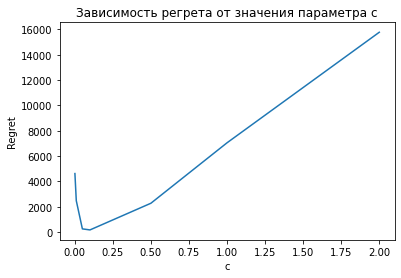

In [36]:
vals = list(filter(lambda x: x != "10.0", regrets.keys()))
plt.plot(list(map(float, vals)), [regrets[v]["regret"] for v in vals])
plt.title("Зависимость регрета от значения параметра c")
plt.xlabel("c")
plt.ylabel("Regret")
plt.show()

In [15]:
output['regret'], output['regret']/output['rounds'],  output['total_banners'] # c == 0.01

(2473.9883190095406, 0.012369941595047703, 184)

In [20]:
policy = UCB(c=0.1)
# seed for homework
seed = 18475
np.random.seed(seed=seed)

start = time.time()
output = simulation(policy, n=200000, seed=seed)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


281.45056438446045

**Регрет уменьшился в 10 раз**

In [22]:
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(168.1332874875451, 0.0008406664374377255, 184)